In [1]:
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sklearn.preprocessing
import Util

In [2]:
# Set device to GPU for faster processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set parameters
num_samples = 300
num_features = 5
phase_diff = 0.0

# Generate time steps
t = torch.linspace(0, 4 * math.pi, num_samples)

# Generate sine wave tensor
sine_wave = torch.zeros(num_samples, num_features)

for i in range(num_features):
    phase = i * phase_diff
    sine_wave[:, i] = 150 * torch.sin(t + phase) + 150



In [3]:
df = pd.DataFrame(sine_wave)
# create a MinMaxScaler object
scaler = sklearn.preprocessing.MinMaxScaler()

# fit and transform the dataframe
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Text(0, 0.5, 'Output')

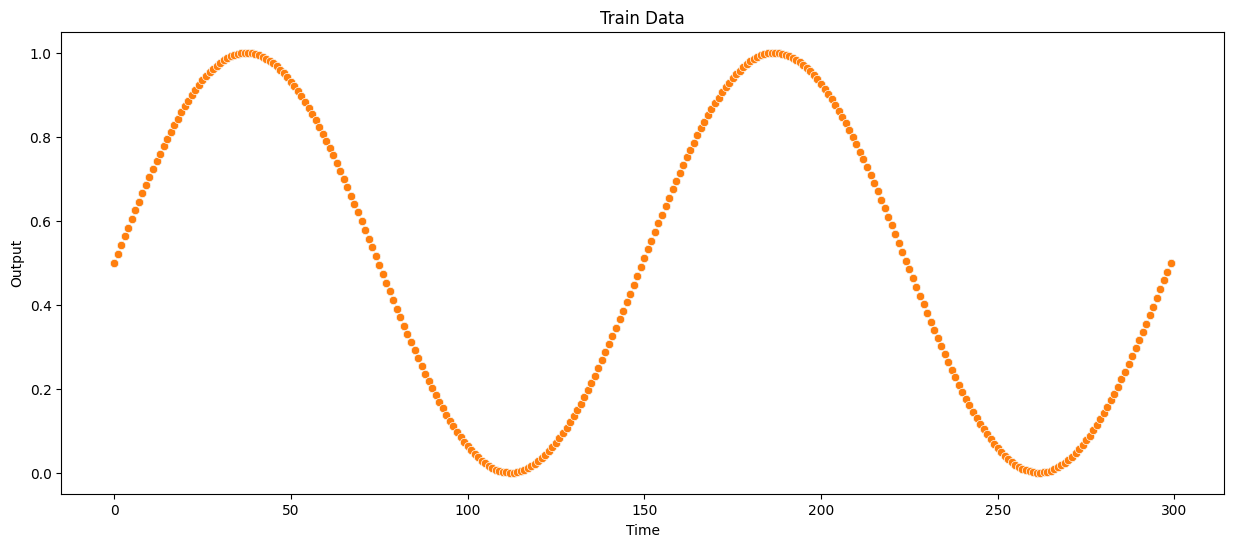

In [4]:
# This is the standardized training data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=scaled_df,x=scaled_df.index, y=scaled_df[0], color='g')
sns.scatterplot(data=scaled_df,x=scaled_df.index, y=scaled_df[1])
sns.scatterplot(data=scaled_df,x=scaled_df.index, y=scaled_df[2])
axes.set_title('Train Data')
axes.set_xlabel("Time")
axes.set_ylabel("Output")

In [5]:
# Specify length of test data, Takes first ## from csv
num_data = num_samples
df_test = scaled_df.iloc[:num_data]

In [6]:
# Input size and output size specify the shape of the tensor fed into the NN
input_size = len(df.columns)
output_size= len(df.columns)
# Hidden Layers and num Layers specify the size of the NN num_layers is arbitrary
hidden_size = len(df.columns)

num_layers = 3
# batch size is the size of data used in training
batch_size = 5
# Learning rate is the step size in optimizer
lr_g=0.00001
lr_d=0.00001
# Number of epochs  is the number of training cycles
num_epochs = 20

In [7]:
# Convert data to numpy
data = df_test.to_numpy()

# Convert numpy array to PyTorch tensor
tensor = torch.tensor(data, dtype=torch.float32)

# Create TimeSeriesDataset object
dataset = TensorDataset(tensor)

# Create DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size, shuffle=False)

In [8]:
# For structured noise inputs
struck_noise = df_test

In [9]:
# This is what a structured noise time step looks like
struck_noise.iloc[:batch_size]

,0,1,2,3,4
0,0.500000,0.500000,0.500000,0.500000,0.500000
1,0.521008,0.521008,0.521008,0.521008,0.521008
2,0.541979,0.541979,0.541979,0.541979,0.541979
3,0.562876,0.562876,0.562876,0.562876,0.562876
4,0.583662,0.583662,0.583662,0.583662,0.583662


In [10]:
noise = torch.randn(batch_size, 5, input_size)
noise

tensor([[[-0.0775, -0.2385,  1.2128, -0.8400, -1.4141],
         [-1.8727, -0.3179,  2.0389, -0.2891,  0.7913],
         [-0.0250,  0.4065,  2.6284, -1.5564,  0.4614],
         [-1.9399,  0.3016,  0.3780, -0.8057,  1.0020],
         [ 0.0057, -0.5952,  0.4106,  0.6439,  0.9653]],

        [[-1.3436,  0.7720,  0.5475,  0.1771,  0.2357],
         [ 0.7036, -1.4336, -0.8419,  0.6856, -1.6494],
         [ 0.8800,  2.1317,  1.0051,  0.3178,  0.9730],
         [-0.1877,  0.0243,  0.2788,  1.9723,  0.2496],
         [-0.4217, -1.1843,  0.4476, -1.3647, -0.0315]],

        [[ 1.9091,  1.1833,  0.7891,  1.9747, -0.7823],
         [ 0.0748, -1.4159, -0.9458, -0.9738, -0.2514],
         [ 1.3533, -0.7146,  0.7155,  0.0896,  1.2619],
         [ 0.1295, -1.4220,  0.9098, -1.6227,  0.2152],
         [-0.4670,  0.2131,  0.4838, -1.9684, -0.6884]],

        [[ 2.1146,  0.5894, -0.4745, -1.5579,  0.0498],
         [-0.1868,  0.7410,  0.1985,  0.0029,  0.7815],
         [ 0.4267,  0.5175,  1.0709, -0.58

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample, dtype=torch.float)

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True, unbiased=False)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [13]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.norm1 = LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.norm2 = LayerNorm(output_size)
        self.dropout = nn.Dropout(0.1)
        self.leakyrelu = nn.LeakyReLU()

    def forward(self, x):
        with torch.backends.cudnn.flags(enabled=False):
            x, _ = self.rnn(x)
            x = self.fc1(x)
            x = self.norm1(x)
            x = self.leakyrelu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.norm2(x)
            return x

In [14]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        with torch.backends.cudnn.flags(enabled=False):
            x, _ = self.rnn(x)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.sigmoid(x)
            
            return x.squeeze()

In [15]:
# def train_gan(generator, discriminator, dataloader, batch_size,input_size, num_epochs, lr_g=0.001, lr_d=0.001, critic_iters=1):
    
#     # Set the GEN and DIS to GPU for Faster computing
#     generator.to(device)
#     discriminator.to(device)
#     # Define Optimizer used for training
#     optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
#     optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

#     # This is the main traiining loop
#     for epoch in range(num_epochs):
#         for i, real_samples in enumerate(dataloader):
#             # Load real samples through data loader
#             real_samples = torch.stack(real_samples, dim=0).to(device)

#             # Train discriminator
#             for critic_iter in range(critic_iters):
#                 #This loop trains the discriminator using the Wasserstien loss
#                 # Critic iter is the number of iterations the discriminator goes through for each loop of the generator
#                 noise = torch.randn(batch_size, 5, input_size, device=device)
#                 fake_samples = generator(noise).detach()
#                 real_output = discriminator(real_samples)
#                 fake_output = discriminator(fake_samples)

#                 # Calculate Wasserstein loss
#                 loss_d = -torch.mean(real_output) + torch.mean(fake_output)

#                 # Gradient penalty
#                 eps = torch.rand(batch_size, 5, device=device)
#                 interpolated = eps * real_samples + (1 - eps) * fake_samples
#                 interpolated.requires_grad = True
#                 interpolated_output = discriminator(interpolated)
#                 gradients = torch.autograd.grad(outputs=interpolated_output, inputs=interpolated,
#                                                 grad_outputs=torch.ones_like(interpolated_output),
#                                                 create_graph=True, retain_graph=True)[0]
#                 gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
#                 loss_d += 10 * gradient_penalty
#                 # Back propagate the training weights and bias
#                 optimizer_d.zero_grad()
#                 loss_d.backward()
#                 optimizer_d.step()

#             # Train generator
#             noise = torch.randn(batch_size, 5, input_size, device=device)
#             fake_samples = generator(noise)
#             fake_output = discriminator(fake_samples)
#             loss_g = -torch.mean(fake_output)
#             # Back propagate the training weights and bias
#             optimizer_g.zero_grad()
#             loss_g.backward()
#             optimizer_g.step()

#             if i % 100 == 0:
#                 print(f"Epoch {epoch+1}/{num_epochs} | Discriminator Loss: {loss_d.item():.4f} | Generator Loss: {loss_g.item():.8f}")
                
                
#     # Create folder if it doesn't exist
#     if not os.path.exists('weights'):
#         os.makedirs('weights')

#     # Save generator and discriminator models to the 'weights' folder
#     torch.save(generator.state_dict(), 'weights/generator_weights.pth')
#     torch.save(discriminator.state_dict(), 'weights/discriminator_weights.pth')

In [16]:

def train_gan(generator, discriminator, dataloader, batch_size,input_size, num_epochs, lr_g=0.001, lr_d=0.001, critic_iters=2):
    
    # Set the GEN and DIS to GPU for Faster computing
    generator.to(device)
    discriminator.to(device)
    # Define Optimizer used for training
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

    # This is the main traiining loop
    for epoch in range(num_epochs):
        for i, real_samples in enumerate(dataloader):
            # Load real samples through data loader
            real_samples = torch.stack(real_samples, dim=0).to(device)

            # Train discriminator
            for critic_iter in range(critic_iters):
                #This loop trains the discriminator using the Wasserstien loss
                # Critic iter is the number of iterations the discriminator goes through for each loop of the generator
                noise = torch.randn(batch_size, 5, input_size, device=device)
#                 noise = real_samples
                fake_samples = generator(noise).detach()
                real_output = discriminator(real_samples)
                fake_output = discriminator(fake_samples)

                # Calculate Wasserstein loss
                loss_d = -torch.mean(real_output) + torch.mean(fake_output)

                # Gradient penalty
                eps = torch.rand(batch_size, 5, device=device)
                interpolated = eps * real_samples + (1 - eps) * fake_samples
                interpolated.requires_grad = True
                interpolated_output = discriminator(interpolated)
                gradients = torch.autograd.grad(outputs=interpolated_output, inputs=interpolated,
                                                grad_outputs=torch.ones_like(interpolated_output),
                                                create_graph=True, retain_graph=True)[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                loss_d += 10 * gradient_penalty
                # Back propagate the training weights and bias
                optimizer_d.zero_grad()
                loss_d.backward()
                optimizer_d.step()

            # Train generator
            noise = torch.randn(batch_size, 5, input_size, device=device)
#             noise = real_samples
            fake_samples = generator(noise)
            fake_output = discriminator(fake_samples)
            loss_g = -torch.mean(fake_output)
            # Back propagate the training weights and bias
            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()

            if i % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} | Discriminator Loss: {loss_d.item():.4f} | Generator Loss: {loss_g.item():.8f}")
                
                
    # Create folder if it doesn't exist
    if not os.path.exists('weights'):
        os.makedirs('weights')

    # Save generator and discriminator models to the 'weights' folder
    torch.save(generator.state_dict(), 'weights/generator_weights.pth')
    torch.save(discriminator.state_dict(), 'weights/discriminator_weights.pth')

In [17]:
# helps visualize the input to the training function
for i, real_samples in enumerate(dataloader):
            # Load real samples through data loader
            real_samples = torch.stack(real_samples, dim=0).to(device)
            print(real_samples)


tensor([[[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5210, 0.5210, 0.5210, 0.5210, 0.5210],
         [0.5420, 0.5420, 0.5420, 0.5420, 0.5420],
         [0.5629, 0.5629, 0.5629, 0.5629, 0.5629],
         [0.5837, 0.5837, 0.5837, 0.5837, 0.5837]]], device='cuda:0')
tensor([[[0.6043, 0.6043, 0.6043, 0.6043, 0.6043],
         [0.6248, 0.6248, 0.6248, 0.6248, 0.6248],
         [0.6450, 0.6450, 0.6450, 0.6450, 0.6450],
         [0.6650, 0.6650, 0.6650, 0.6650, 0.6650],
         [0.6847, 0.6847, 0.6847, 0.6847, 0.6847]]], device='cuda:0')
tensor([[[0.7040, 0.7040, 0.7040, 0.7040, 0.7040],
         [0.7230, 0.7230, 0.7230, 0.7230, 0.7230],
         [0.7416, 0.7416, 0.7416, 0.7416, 0.7416],
         [0.7598, 0.7598, 0.7598, 0.7598, 0.7598],
         [0.7775, 0.7775, 0.7775, 0.7775, 0.7775]]], device='cuda:0')
tensor([[[0.7947, 0.7947, 0.7947, 0.7947, 0.7947],
         [0.8115, 0.8115, 0.8115, 0.8115, 0.8115],
         [0.8276, 0.8276, 0.8276, 0.8276, 0.8276],
         [0.8432, 0.8432,

In [18]:
# Define generator and discriminator
generator = Generator(input_size,output_size, hidden_size, num_layers)
discriminator = Discriminator(input_size, hidden_size,num_layers)

In [19]:
# Train the WGAN
train_gan(generator, discriminator, dataloader,batch_size,input_size, num_epochs, lr_g, lr_d)

Epoch 1/20 | Discriminator Loss: 9.9842 | Generator Loss: -0.44154665
Epoch 2/20 | Discriminator Loss: 9.9863 | Generator Loss: -0.44099048
Epoch 3/20 | Discriminator Loss: 9.9851 | Generator Loss: -0.44212741
Epoch 4/20 | Discriminator Loss: 9.9805 | Generator Loss: -0.44316503
Epoch 5/20 | Discriminator Loss: 9.9770 | Generator Loss: -0.44320625
Epoch 6/20 | Discriminator Loss: 9.9751 | Generator Loss: -0.44264397
Epoch 7/20 | Discriminator Loss: 9.9783 | Generator Loss: -0.44426373
Epoch 8/20 | Discriminator Loss: 9.9739 | Generator Loss: -0.44236159
Epoch 9/20 | Discriminator Loss: 9.9757 | Generator Loss: -0.44208938
Epoch 10/20 | Discriminator Loss: 9.9686 | Generator Loss: -0.44269526
Epoch 11/20 | Discriminator Loss: 9.9702 | Generator Loss: -0.44441572
Epoch 12/20 | Discriminator Loss: 9.9623 | Generator Loss: -0.44355330
Epoch 13/20 | Discriminator Loss: 9.9592 | Generator Loss: -0.44310555
Epoch 14/20 | Discriminator Loss: 9.9585 | Generator Loss: -0.44495985
Epoch 15/20 | D

Rather than feed random noise the original sine wave is fed in to see if it has any impact

In [20]:
# Generate the new data, size is the number of time points
# z = torch.randn(size=(600, input_size), device=device)
struck_noise = tensor.to(device)
z = struck_noise
with torch.no_grad():
    fake_samples = generator(z)

In [21]:
# Convert tensor to CPU
fake_samples = fake_samples.cpu().numpy()

Text(0, 0.5, 'Output')

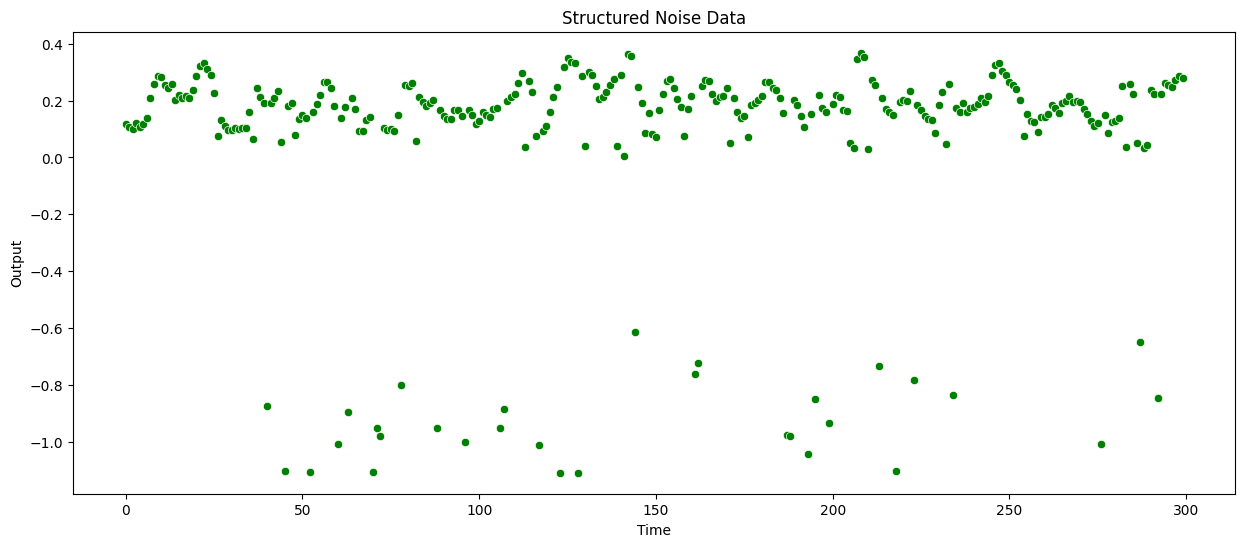

In [32]:
# This is what the Generated time series looks like
df_gen = pd.DataFrame(fake_samples)

# Plot the generated data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_gen,x=df_gen.index, y=df_gen[1], color='g')

axes.set_title('Structured Noise Data')
axes.set_xlabel("Time")
axes.set_ylabel("Output")
# plt.ylim(1.0, 1.5)

Here random noise is fed

In [23]:
# Generate the new data, size is the number of time points
z = torch.randn(size=(300, input_size), device=device)
# struck_noise = tensor.to(device)
# z = struck_noise
with torch.no_grad():
    fake_samples = generator(z)

# Convert tensor to CPU
fake_samples = fake_samples.cpu().numpy()

Text(0, 0.5, 'Output')

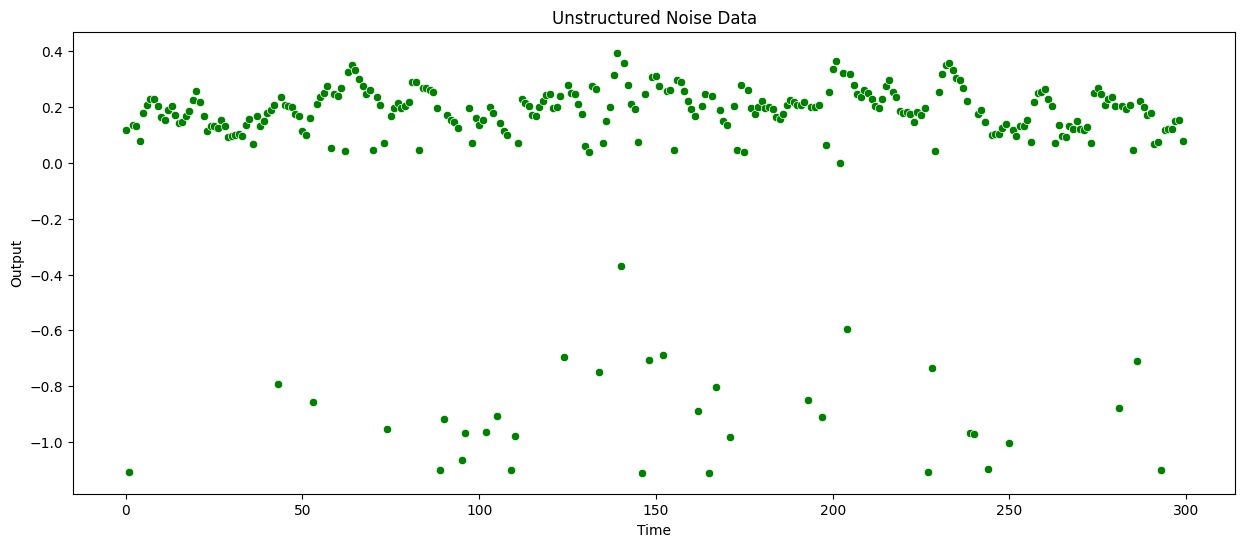

In [24]:
# This is what the Generated time series looks like
df_gen = pd.DataFrame(fake_samples)

# Plot the generated data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_gen,x=df_gen.index, y=df_gen[1], color='g')

axes.set_title('Unstructured Noise Data')
axes.set_xlabel("Time")
axes.set_ylabel("Output")
# plt.ylim(1.0, 1.5)

In [25]:
# Inverse scaling the data
original_df = pd.DataFrame(scaler.inverse_transform(df_gen), columns=df_gen.columns)

Text(0, 0.5, 'Output')

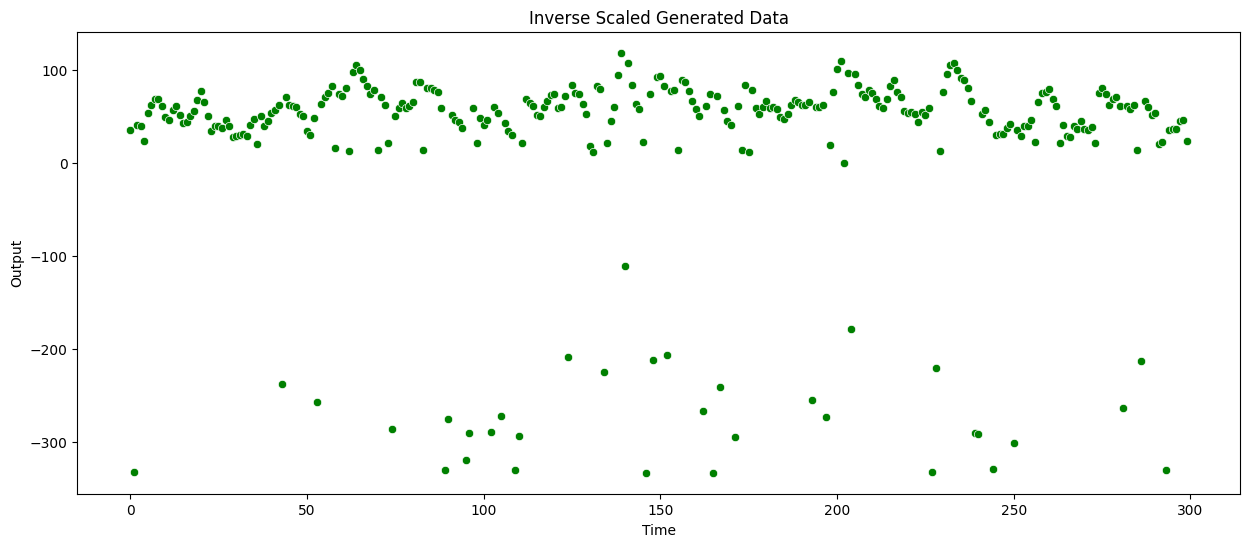

In [26]:
# Plot the generated data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=original_df,x=original_df.index, y=original_df[1], color='g')

axes.set_title('Inverse Scaled Generated Data')
axes.set_xlabel("Time")
axes.set_ylabel("Output")

This part of the code loads the saved weights and bias 

In [27]:
# Create new generator and discriminator models
new_generator = Generator(input_size,output_size, hidden_size, num_layers).to(device)
new_discriminator = Discriminator(input_size, hidden_size, num_layers).to(device)

# Load saved weights into models
new_generator.load_state_dict(torch.load('weights/generator_weights.pth'))
new_discriminator.load_state_dict(torch.load('weights/discriminator_weights.pth'))

<All keys matched successfully>

In [28]:
# Train the WGAN
train_gan(new_generator, new_discriminator, dataloader,batch_size,input_size, num_epochs, lr_g, lr_d)

Epoch 1/20 | Discriminator Loss: 9.9344 | Generator Loss: -0.44458529
Epoch 2/20 | Discriminator Loss: 9.9232 | Generator Loss: -0.44397184
Epoch 3/20 | Discriminator Loss: 9.9276 | Generator Loss: -0.44643107
Epoch 4/20 | Discriminator Loss: 9.9129 | Generator Loss: -0.44551143
Epoch 5/20 | Discriminator Loss: 9.9028 | Generator Loss: -0.44549763
Epoch 6/20 | Discriminator Loss: 9.9069 | Generator Loss: -0.44244862
Epoch 7/20 | Discriminator Loss: 9.9105 | Generator Loss: -0.44703293
Epoch 8/20 | Discriminator Loss: 9.9029 | Generator Loss: -0.44672903
Epoch 9/20 | Discriminator Loss: 9.8878 | Generator Loss: -0.44446251
Epoch 10/20 | Discriminator Loss: 9.9281 | Generator Loss: -0.44521812
Epoch 11/20 | Discriminator Loss: 9.8829 | Generator Loss: -0.44608009
Epoch 12/20 | Discriminator Loss: 9.8959 | Generator Loss: -0.44891500
Epoch 13/20 | Discriminator Loss: 9.8982 | Generator Loss: -0.44371924
Epoch 14/20 | Discriminator Loss: 9.8611 | Generator Loss: -0.44393525
Epoch 15/20 | D

In [29]:
# Generate the new data, size is the number of time points
z = torch.randn(size=(300, input_size), device=device)
with torch.no_grad():
    fake_samples = generator(z)

In [30]:
# Convert tensor to CPU
fake_samples = fake_samples.cpu().numpy()

Text(0, 0.5, 'Output')

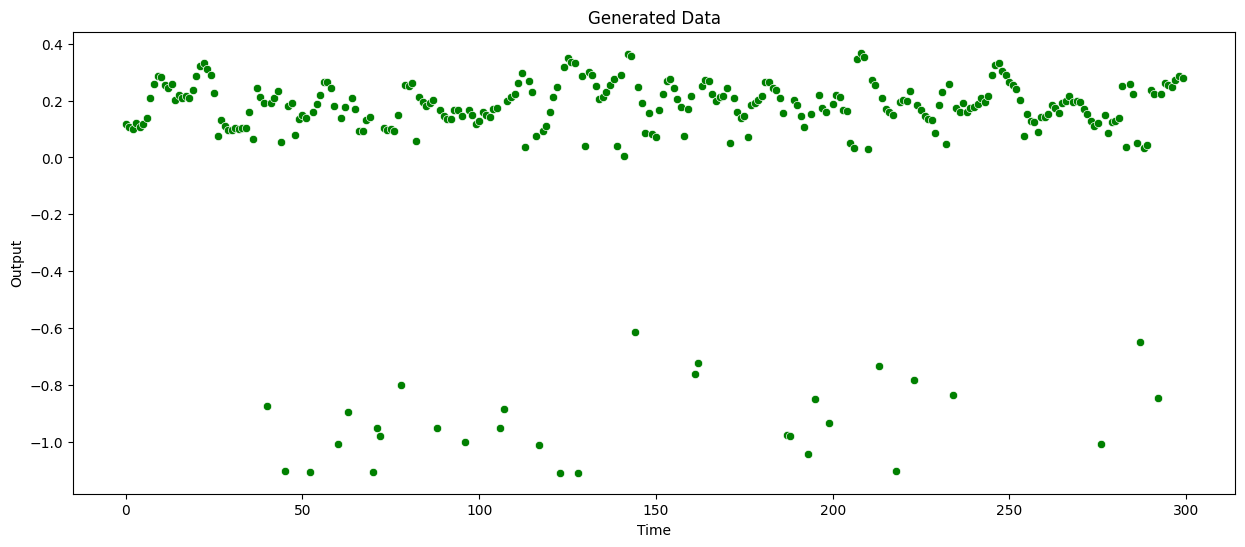

In [31]:
# This is what the Generated time series looks like
df_gen = pd.DataFrame(fake_samples)

# Plot the generated data
fig, axes = plt.subplots(figsize=(15, 6))
sns.scatterplot(data=df_gen,x=df_gen.index, y=df_gen[1], color='g')

axes.set_title('Generated Data')
axes.set_xlabel("Time")
axes.set_ylabel("Output")
# plt.ylim(1.1, 1.4)